# Exploring Neural Spiking Data in Response to Transcranial Focused Ultrasound

**IMPORTANT NOTICE**: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please exercise caution when interpreting the code or results.

This notebook explores Dandiset 001363: "Neural Spiking Data in the Rat Somatosensory Cortex Using a Flexible Electrode Responding to Transcranial Focused Ultrasound"

## Dataset Overview

This Dandiset contains neural recordings from rats in response to transcranial focused ultrasound stimulation (tFUS) on the somatosensory cortex. The researchers used a 128-element array transducer and a chronically implanted ultraflexible nanoelectric thread electrode to study neural responses to different ultrasound parameters.

The key experimental parameters varied in this study include:

1. **In situ ultrasound pressure**: 100, 400, 700, 1000, and 1300 kPa
2. **Duty cycle** (with constant pulse repetition frequency at 1500 Hz): 0.6%, 6%, 30%, 60%, and 90% 
3. **Pulse repetition frequency (PRF)** (with constant duty cycle of 30%): 30, 300, 1500, 3000, and 4500 Hz

Each recording contains 505 trials with stimulation occurring every 2 seconds (with a 10% jitter).

In [1]:
# Required packages - make sure these are installed in your environment
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import pynwb
import os

# Optional: Set seaborn style for better-looking plots
sns.set_theme()

## Loading and Exploring the Dandiset

First, let's use the DANDI API to get information about the Dandiset and list its assets.

In [2]:
from dandi.dandiapi import DandiAPIClient

# Create a client
client = DandiAPIClient()

# Get the Dandiset
dandiset = client.get_dandiset("001363")
assets = list(dandiset.get_assets())

# Use raw metadata to avoid validation errors
raw_metadata = dandiset.get_raw_metadata()

# Display basic Dandiset information
print(f"Dandiset Name: {raw_metadata['name']}")
print(f"Description: {raw_metadata['description'][:500]}...")
print(f"Number of assets: {len(assets)}")

# Display some of the contributors
print("\nContributors:")
for contributor in raw_metadata.get('contributor', [])[:5]:
    print(f"- {contributor}")

Dandiset Name: Neural Spiking Data in the Rat Somatosensory Cortex Using a Flexible Electrode Responding to Transcranial Focused Ultrasound
Description: In this study, we investigate the neuronal response to transcranial focused ultrasound stimulation (tFUS) on the somatosensory cortex using a 128-element array transducer and a chronically implanted ultraflexible nanoelectric thread electrode. This flexible electrode allows us to  study higher intensities of tFUS which are impossible with a rigid electrode due to the vibration artifacts that are created. Here we test 5 different levels of in situ ultrasound pressure including 100, 400, 700, 1000...
Number of assets: 55

Contributors:
- {'name': 'Ramachandran, Sandhya', 'email': 's.ramachandran8@gmail.com', 'roleName': ['dcite:ContactPerson'], 'schemaKey': 'Person', 'affiliation': [], 'includeInCitation': True}
- {'name': 'Gao, Huan', 'schemaKey': 'Person', 'includeInCitation': True}
- {'name': 'Yu, Kai', 'schemaKey': 'Person', 'include

## Exploring the Assets

Let's examine the assets in this Dandiset to understand what's available.

In [3]:
# List the first 10 assets
print("First 10 assets:")
for i, asset in enumerate(assets[:10]):
    print(f"{i+1}. {asset.path} (Size: {asset.size/1e6:.2f} MB)")

# Group assets by subject
subjects = {}
for asset in assets:
    path_parts = asset.path.split('/')
    if len(path_parts) > 0:
        subject = path_parts[0]
        if subject not in subjects:
            subjects[subject] = []
        subjects[subject].append(asset.path)

# Display the number of recordings per subject
print("\nNumber of recordings per subject:")
for subject, paths in subjects.items():
    print(f"{subject}: {len(paths)} recordings")

First 10 assets:
1. sub-BH643/sub-BH643_ecephys.nwb (Size: 3186.02 MB)
2. sub-BH643/sub-BH643_ses-20241220T182204_ecephys.nwb (Size: 2995.71 MB)
3. sub-BH643/sub-BH643_ses-20241220T174647_ecephys.nwb (Size: 3154.04 MB)
4. sub-BH643/sub-BH643_ses-20241220T195303_ecephys.nwb (Size: 3186.02 MB)
5. sub-BH643/sub-BH643_ses-20241220T180423_ecephys.nwb (Size: 3185.24 MB)
6. sub-BH643/sub-BH643_ses-20241220T184135_ecephys.nwb (Size: 3151.95 MB)
7. sub-BH643/sub-BH643_ses-20241220T192930_ecephys.nwb (Size: 312.81 MB)
8. sub-BH643/sub-BH643_ses-20241220T185844_ecephys.nwb (Size: 3825.66 MB)
9. sub-BH643/sub-BH643_ses-20241220T201136_ecephys.nwb (Size: 3140.28 MB)
10. sub-BH643/sub-BH643_ses-20241220T204916_ecephys.nwb (Size: 3139.10 MB)

Number of recordings per subject:
sub-BH643: 14 recordings
sub-BH625: 13 recordings
sub-BH589: 6 recordings
sub-BH627: 9 recordings
sub-BH633: 13 recordings


## Loading Data from an NWB File

Now let's load an NWB file from the Dandiset. We'll use the `lindi` package which allows efficient access to remote NWB files without downloading the entire file.

In [4]:
import lindi

# Select the first file from subject BH589
asset_id = "59d1acbb-5ad5-45f1-b211-c2e311801824"  # First session from subject BH589

# URL for loading the data through lindi
lindi_url = f"https://lindi.neurosift.org/dandi/dandisets/001363/assets/{asset_id}/nwb.lindi.json"

# Load the file
f = lindi.LindiH5pyFile.from_lindi_file(lindi_url)
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Examining NWB File Metadata

Let's look at the metadata in the NWB file to understand the experiment and recordings better.

In [5]:
# Display session information
print(f"Session description: {nwb.session_description}")
print(f"Identifier: {nwb.identifier}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Institution: {nwb.institution}")

# Display subject information
print("\nSubject Information:")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Species: {nwb.subject.species}")
print(f"Sex: {nwb.subject.sex}")
print(f"Age: {nwb.subject.age}")

Session description: Rat Ultrasound Array Stimulation
Identifier: BH589_1500_200_67_25V
Session start time: 2024-08-27 16:04:57-04:00
Institution: Carnegie Mellon University

Subject Information:
Subject ID: BH589
Species: Rattus norvegicus
Sex: M
Age: P24W


## Exploring the Acquired Neural Data

The dataset contains electrical recordings from a 32-channel ultraflexible nanoelectric thread electrode. Let's examine the structure of this data.

In [6]:
# Get the electrical series data
electrical_series = nwb.acquisition["ElectricalSeries"]

# Display information about the data
print(f"Data shape: {electrical_series.data.shape}")
print(f"Sampling rate: {electrical_series.rate} Hz")
print(f"Starting time: {electrical_series.starting_time} seconds")

# Examine electrodes
electrodes = nwb.electrodes
print(f"\nNumber of electrodes: {len(electrodes.id[:])}")
print(f"Electrode columns: {electrodes.colnames}")

Data shape: (31084544, 32)
Sampling rate: 24414.0625 Hz
Starting time: 0.0 seconds

Number of electrodes: 32
Electrode columns: ('x', 'y', 'z', 'imp', 'location', 'filtering', 'group', 'group_name')


## Examining Trial Structure

Each recording contains multiple trials of tFUS stimulation. Let's examine the trial structure to understand the experimental design better.

Number of trials: 500

Trial duration (mean ± std): 1.5000 ± 0.0000 seconds
Inter-trial interval (mean ± std): 2.5014 ± 0.1441 seconds


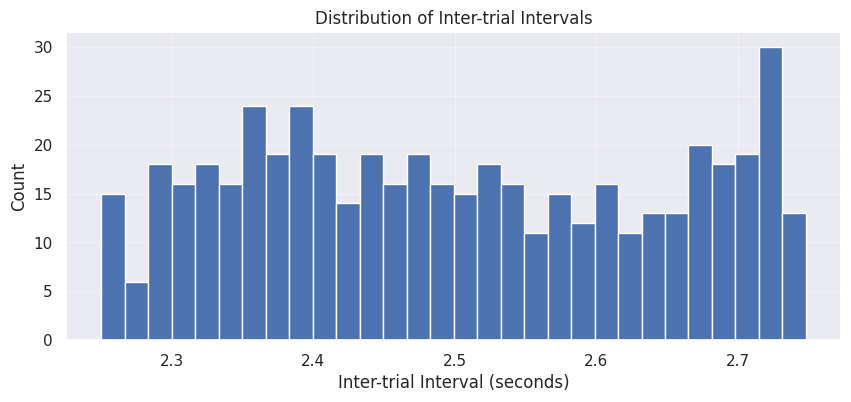

In [7]:
# Get trial information
trials = nwb.intervals["trials"]
trial_start_times = trials['start_time'][:]
trial_stop_times = trials['stop_time'][:]

print(f"Number of trials: {len(trial_start_times)}")

# Calculate trial durations
trial_durations = trial_stop_times - trial_start_times

# Calculate inter-trial intervals
inter_trial_intervals = np.diff(trial_start_times)

# Print summary statistics
print(f"\nTrial duration (mean ± std): {np.mean(trial_durations):.4f} ± {np.std(trial_durations):.4f} seconds")
print(f"Inter-trial interval (mean ± std): {np.mean(inter_trial_intervals):.4f} ± {np.std(inter_trial_intervals):.4f} seconds")

# Plot the histogram of inter-trial intervals
plt.figure(figsize=(10, 4))
plt.hist(inter_trial_intervals, bins=30)
plt.xlabel('Inter-trial Interval (seconds)')
plt.ylabel('Count')
plt.title('Distribution of Inter-trial Intervals')
plt.grid(True, alpha=0.3)

## Visualizing Raw Neural Data

Let's visualize the raw neural activity for a single trial to see what the data looks like.

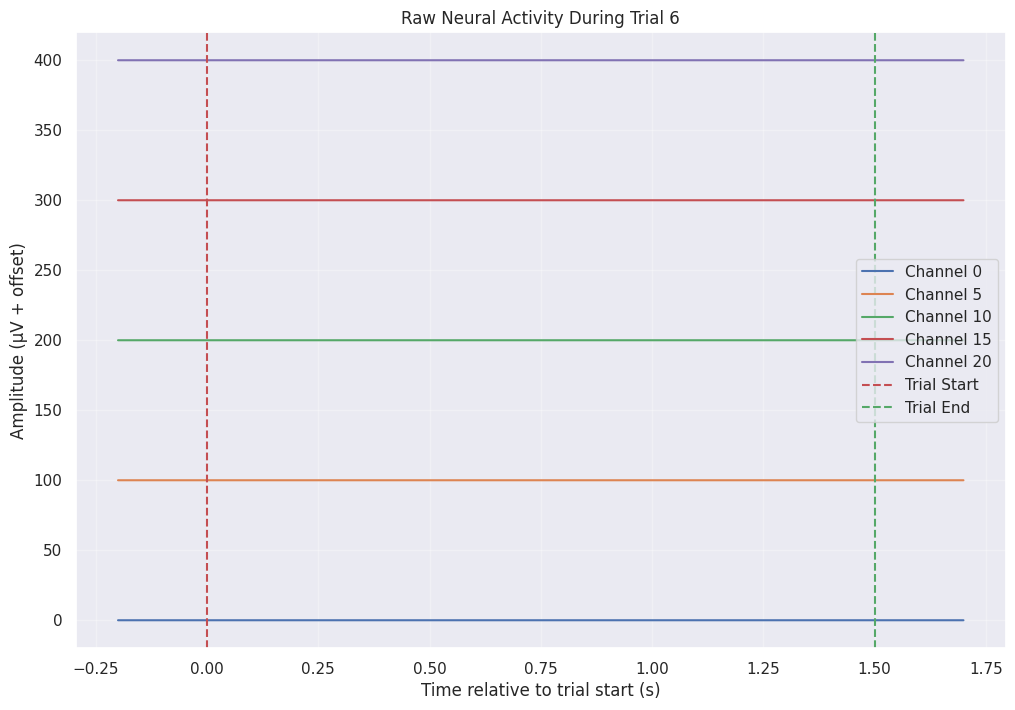

In [8]:
# Select a trial to visualize (e.g., trial 5)
trial_index = 5  # Using an earlier trial to potentially reduce data access time
trial_start = trial_start_times[trial_index]
trial_stop = trial_stop_times[trial_index]

# Define a smaller window around the trial
window_before = 0.2  # seconds before trial (reduced)
window_after = 0.2   # seconds after trial (reduced)

# Calculate indices
start_idx = int((trial_start - window_before) * electrical_series.rate)
stop_idx = int((trial_stop + window_after) * electrical_series.rate)

# Check boundaries
if start_idx < 0:
    start_idx = 0
if stop_idx >= electrical_series.data.shape[0]:
    stop_idx = electrical_series.data.shape[0] - 1

# Select a subset of channels to visualize
channels_to_plot = [0, 5, 10, 15, 20]  # A few representative channels

# Load the data for these channels only
data_subset = electrical_series.data[start_idx:stop_idx, channels_to_plot]

# Create time axis in seconds relative to trial start
time_axis = np.arange(data_subset.shape[0]) / electrical_series.rate
time_axis = time_axis - window_before

# Plot the data
plt.figure(figsize=(12, 8))

# Plot each channel with an offset
offsets = np.arange(len(channels_to_plot)) * 100  # Offset for visualization
for i, ch_idx in enumerate(channels_to_plot):
    plt.plot(time_axis, data_subset[:, i] + offsets[i], label=f'Channel {ch_idx}')

# Add vertical lines for trial start and end
plt.axvline(x=0, color='r', linestyle='--', label='Trial Start')
plt.axvline(x=trial_stop-trial_start, color='g', linestyle='--', label='Trial End')

plt.xlabel('Time relative to trial start (s)')
plt.ylabel('Amplitude (μV + offset)')
plt.title(f'Raw Neural Activity During Trial {trial_index+1}')
plt.legend()
plt.grid(True, alpha=0.3)

## Frequency Analysis of Neural Activity

Let's examine how the frequency content of the neural signal changes before, during, and after tFUS stimulation.

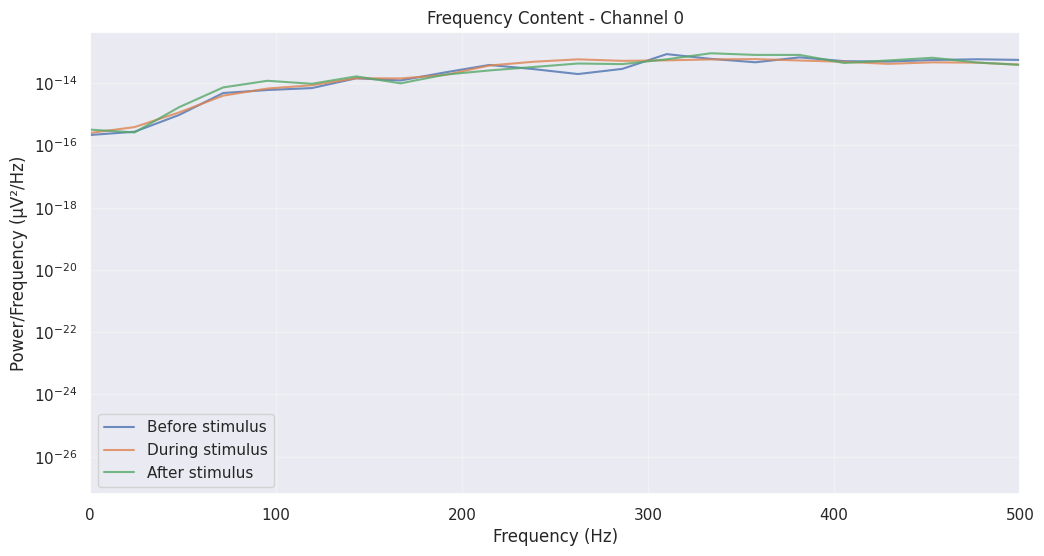

In [9]:
# Select a single channel for frequency analysis
channel_to_analyze = 0

# Get data for the selected channel
channel_data = data_subset[:, channels_to_plot.index(channel_to_analyze)]

# Define time windows
before_stim = time_axis < 0  # Before stimulation
during_stim = (time_axis >= 0) & (time_axis <= trial_stop - trial_start)  # During stimulation
after_stim = time_axis > (trial_stop - trial_start)  # After stimulation

# Calculate power spectra using Welch's method
f_before, psd_before = signal.welch(channel_data[before_stim], electrical_series.rate,
                                    nperseg=min(1024, sum(before_stim)))
f_during, psd_during = signal.welch(channel_data[during_stim], electrical_series.rate,
                                    nperseg=min(1024, sum(during_stim)))
f_after, psd_after = signal.welch(channel_data[after_stim], electrical_series.rate,
                                 nperseg=min(1024, sum(after_stim)))

# Plot frequency content
plt.figure(figsize=(12, 6))
plt.semilogy(f_before, psd_before, label='Before stimulus', alpha=0.8)
plt.semilogy(f_during, psd_during, label='During stimulus', alpha=0.8)
plt.semilogy(f_after, psd_after, label='After stimulus', alpha=0.8)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (μV²/Hz)')
plt.title(f'Frequency Content - Channel {channel_to_analyze}')
plt.xlim(0, 500)  # Limit to 0-500 Hz
plt.legend()
plt.grid(True, alpha=0.3)

## Filtering the Data into Different Frequency Bands

Neural signals contain information at different frequency bands. Let's filter the data to isolate local field potentials (LFPs) and high-frequency spike activity.

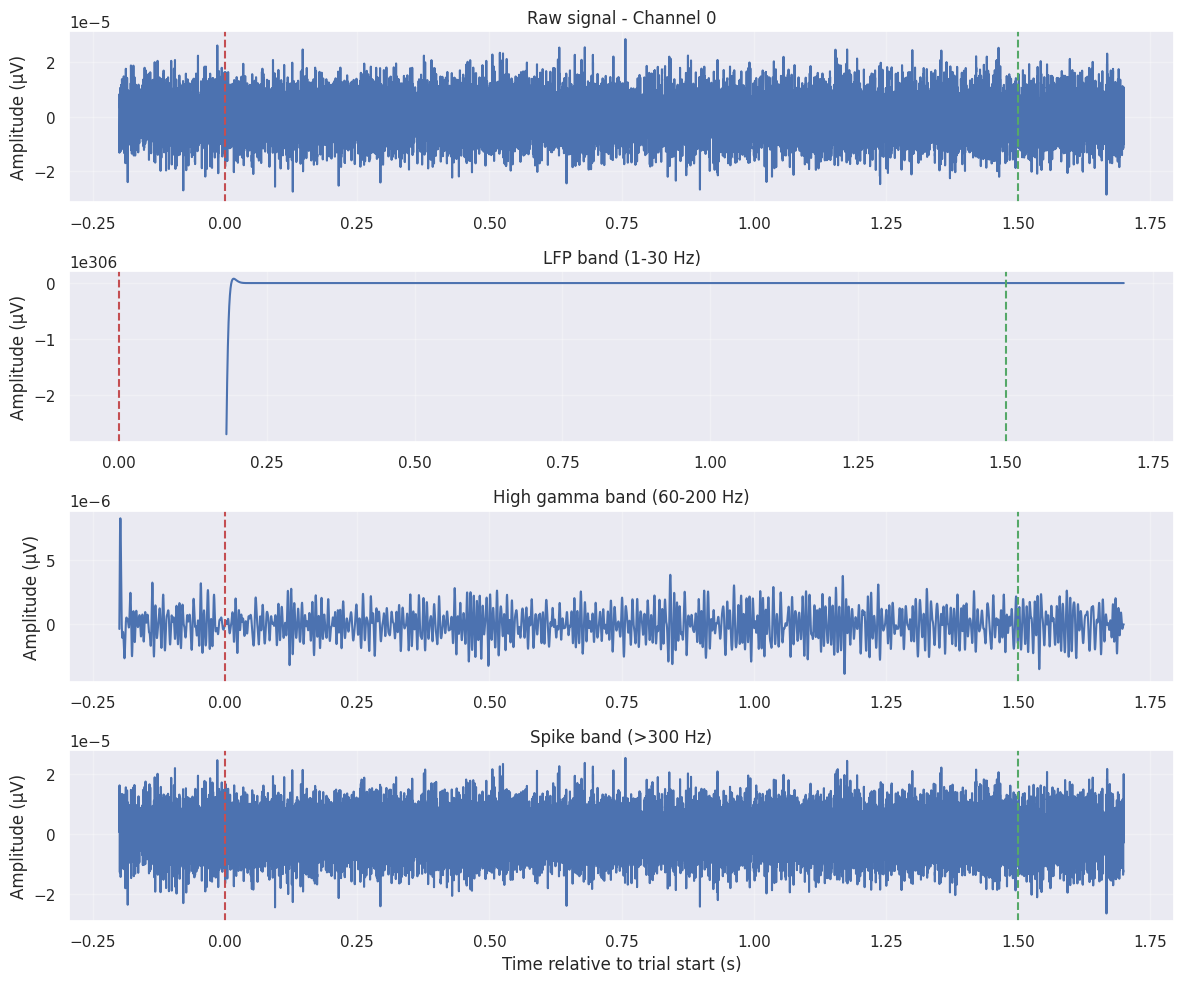

In [10]:
# Apply filters to isolate different frequency components
from scipy import signal

# Get the data from a single channel for a single trial
channel_data = data_subset[:, channels_to_plot.index(channel_to_analyze)]

# 1. LFP band (1-30 Hz)
b_lfp, a_lfp = signal.butter(4, [1, 30], 'bandpass', fs=electrical_series.rate)
lfp_filtered = signal.filtfilt(b_lfp, a_lfp, channel_data)

# 2. High gamma band (60-200 Hz)
b_gamma, a_gamma = signal.butter(4, [60, 200], 'bandpass', fs=electrical_series.rate)
gamma_filtered = signal.filtfilt(b_gamma, a_gamma, channel_data)

# 3. Spike band (>300 Hz)
b_spikes, a_spikes = signal.butter(4, 300, 'highpass', fs=electrical_series.rate)
spike_filtered = signal.filtfilt(b_spikes, a_spikes, channel_data)

# Plot the filtered signals
plt.figure(figsize=(12, 10))

# Raw data
plt.subplot(4, 1, 1)
plt.plot(time_axis, channel_data)
plt.axvline(x=0, color='r', linestyle='--')
plt.axvline(x=trial_stop-trial_start, color='g', linestyle='--')
plt.title(f'Raw signal - Channel {channel_to_analyze}')
plt.ylabel('Amplitude (μV)')
plt.grid(True, alpha=0.3)

# LFP band
plt.subplot(4, 1, 2)
plt.plot(time_axis, lfp_filtered)
plt.axvline(x=0, color='r', linestyle='--')
plt.axvline(x=trial_stop-trial_start, color='g', linestyle='--')
plt.title('LFP band (1-30 Hz)')
plt.ylabel('Amplitude (μV)')
plt.grid(True, alpha=0.3)

# Gamma band
plt.subplot(4, 1, 3)
plt.plot(time_axis, gamma_filtered)
plt.axvline(x=0, color='r', linestyle='--')
plt.axvline(x=trial_stop-trial_start, color='g', linestyle='--')
plt.title('High gamma band (60-200 Hz)')
plt.ylabel('Amplitude (μV)')
plt.grid(True, alpha=0.3)

# Spike band
plt.subplot(4, 1, 4)
plt.plot(time_axis, spike_filtered)
plt.axvline(x=0, color='r', linestyle='--')
plt.axvline(x=trial_stop-trial_start, color='g', linestyle='--')
plt.title('Spike band (>300 Hz)')
plt.xlabel('Time relative to trial start (s)')
plt.ylabel('Amplitude (μV)')
plt.grid(True, alpha=0.3)

plt.tight_layout()

## Time-Frequency Analysis

Let's perform time-frequency analysis to visualize how the spectral content changes over time during the trial.

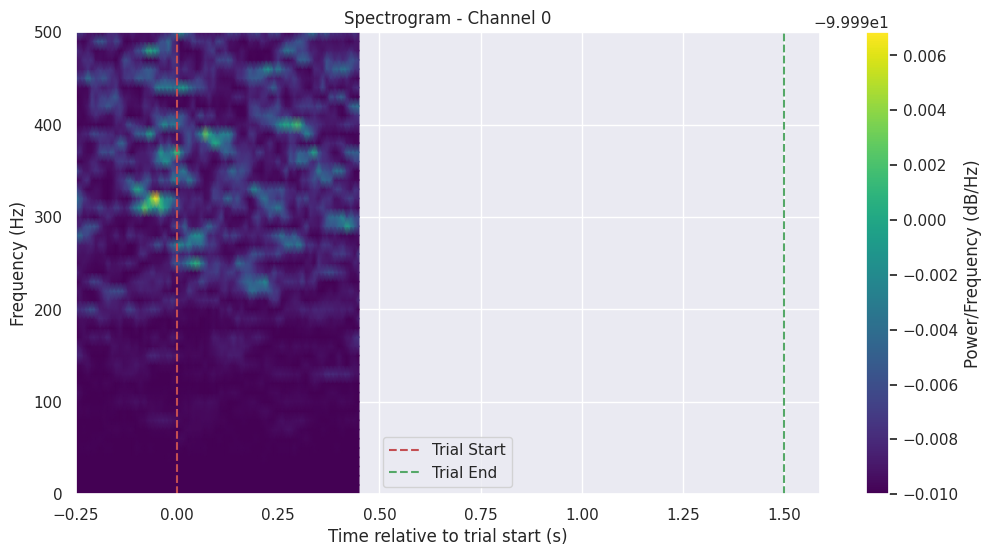

In [11]:
# Create a spectrogram of the signal around a trial
from scipy import signal

# Use a shorter segment to reduce computation time
trial_index = 5
window_before = 0.3  # seconds (reduced)
window_after = 0.5   # seconds (reduced)

trial_start = trial_start_times[trial_index]
trial_stop = trial_stop_times[trial_index]

start_idx = int((trial_start - window_before) * electrical_series.rate)
stop_idx = int((trial_start + window_after) * electrical_series.rate)

# Check boundaries
if start_idx < 0:
    start_idx = 0
if stop_idx >= electrical_series.data.shape[0]:
    stop_idx = electrical_series.data.shape[0] - 1

# Load data for a single channel
channel_to_analyze = 0
data = electrical_series.data[start_idx:stop_idx, channel_to_analyze]

# Create time axis relative to trial start
time_rel = np.arange(len(data)) / electrical_series.rate - window_before

# Compute spectrogram
f, t, Sxx = signal.spectrogram(data, fs=electrical_series.rate,
                               nperseg=int(0.1 * electrical_series.rate),  # 100ms window
                               noverlap=int(0.09 * electrical_series.rate))  # 90% overlap

# Plot spectrogram
plt.figure(figsize=(12, 6))
plt.pcolormesh(t + time_rel[0], f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
plt.colorbar(label='Power/Frequency (dB/Hz)')

# Add vertical lines for trial start and end
plt.axvline(x=0, color='r', linestyle='--', label='Trial Start')
plt.axvline(x=trial_stop - trial_start, color='g', linestyle='--', label='Trial End')

plt.ylabel('Frequency (Hz)')
plt.xlabel('Time relative to trial start (s)')
plt.title(f'Spectrogram - Channel {channel_to_analyze}')
plt.ylim(0, 500)  # Limit to 0-500 Hz
plt.legend()

## Spike Detection

Now let's detect spikes in the neural signal to analyze spiking activity in response to tFUS stimulation.

In [12]:
def detect_spikes(data, threshold_factor=5.0, fs=24414.0625):
    """
    Detect spikes in neural data using a threshold-crossing method.

    Parameters:
    -----------
    data : array
        The neural data.
    threshold_factor : float
        Factor to multiply the standard deviation for threshold setting.
    fs : float
        Sampling rate in Hz.

    Returns:
    --------
    spike_times : array
        Time points (in seconds) of detected spikes.
    """
    # Filter data (300 Hz highpass) to isolate spikes
    b, a = signal.butter(3, 300/(fs/2), 'highpass')
    filtered = signal.filtfilt(b, a, data)

    # Compute threshold based on filtered data
    threshold = threshold_factor * np.std(filtered)

    # Detect threshold crossings (negative-going)
    spike_indices = np.where(filtered < -threshold)[0]

    # Ensure spikes are separated by at least 1 ms (refractory period)
    if len(spike_indices) > 1:
        spike_times = [spike_indices[0]]
        for i in range(1, len(spike_indices)):
            if spike_indices[i] > spike_indices[i-1] + int(0.001 * fs):  # 1ms refractory period
                spike_times.append(spike_indices[i])
        return np.array(spike_times) / fs  # Convert to seconds
    return spike_indices / fs  # Convert to seconds

Let's apply the spike detection to our data and visualize the results for one trial.

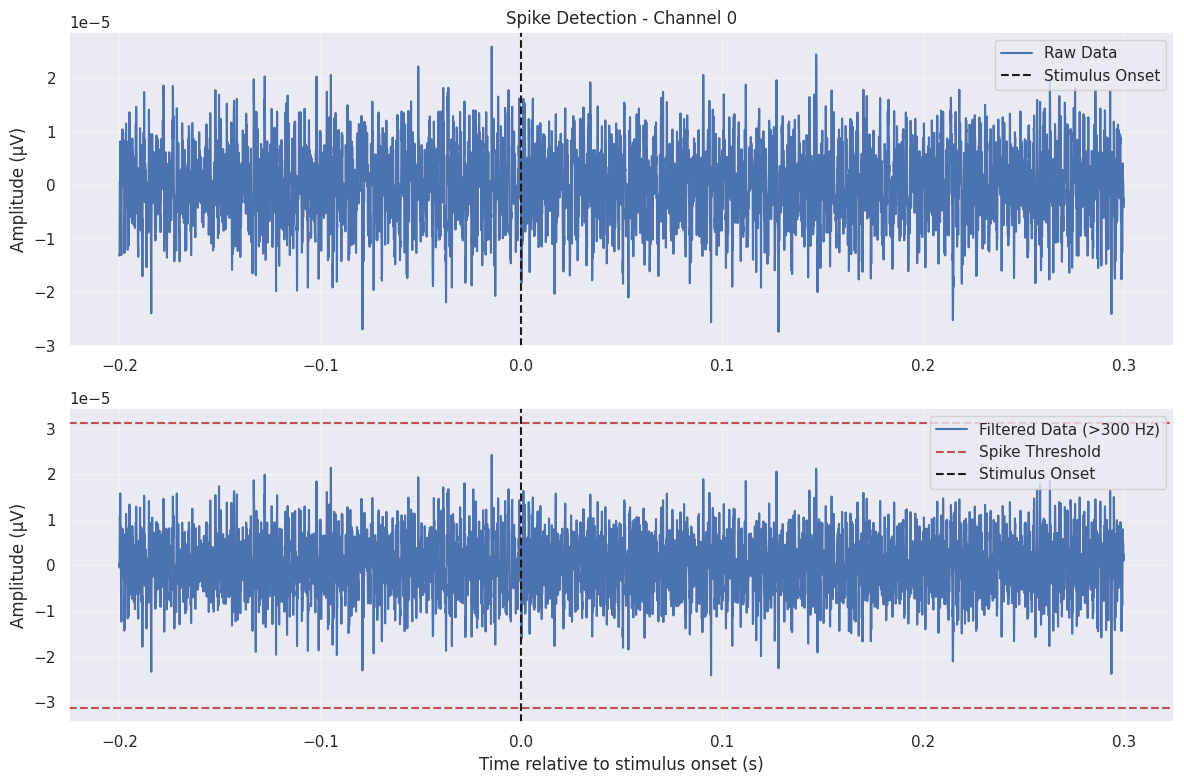

In [13]:
# Select a shorter segment for spike detection visualization
window_before = 0.2  # seconds
window_after = 0.3   # seconds

start_idx = int((trial_start - window_before) * electrical_series.rate)
stop_idx = int((trial_start + window_after) * electrical_series.rate)

# Check boundaries
if start_idx < 0:
    start_idx = 0
if stop_idx >= electrical_series.data.shape[0]:
    stop_idx = electrical_series.data.shape[0] - 1

# Load data
channel_to_analyze = 0
data = electrical_series.data[start_idx:stop_idx, channel_to_analyze]
time_rel = np.arange(len(data)) / electrical_series.rate - window_before

# Detect spikes
spike_times = detect_spikes(data, threshold_factor=5.0, fs=electrical_series.rate)
spike_times_rel = spike_times - window_before  # Convert to time relative to trial start

# Filter data for visualization
b, a = signal.butter(3, 300/(electrical_series.rate/2), 'highpass')
filtered = signal.filtfilt(b, a, data)

# Plot raw and filtered data with detected spikes
plt.figure(figsize=(12, 8))

# Raw data
plt.subplot(2, 1, 1)
plt.plot(time_rel, data, label='Raw Data')
if len(spike_times_rel) > 0:
    # For each spike, find the nearest index in the time vector
    spike_indices = [np.abs(time_rel - t).argmin() for t in spike_times_rel]
    plt.scatter(spike_times_rel, data[spike_indices], color='red', s=50, label='Detected Spikes')
plt.axvline(x=0, color='k', linestyle='--', label='Stimulus Onset')
plt.title(f'Spike Detection - Channel {channel_to_analyze}')
plt.ylabel('Amplitude (μV)')
plt.legend()
plt.grid(True, alpha=0.3)

# Filtered data
plt.subplot(2, 1, 2)
plt.plot(time_rel, filtered, label='Filtered Data (>300 Hz)')
threshold = 5.0 * np.std(filtered)
plt.axhline(y=-threshold, color='r', linestyle='--', label='Spike Threshold')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axvline(x=0, color='k', linestyle='--', label='Stimulus Onset')
plt.xlabel('Time relative to stimulus onset (s)')
plt.ylabel('Amplitude (μV)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

## Analyzing Spike Rates Across Multiple Trials

Let's analyze how spike rates change before, during, and after tFUS stimulation across multiple trials.

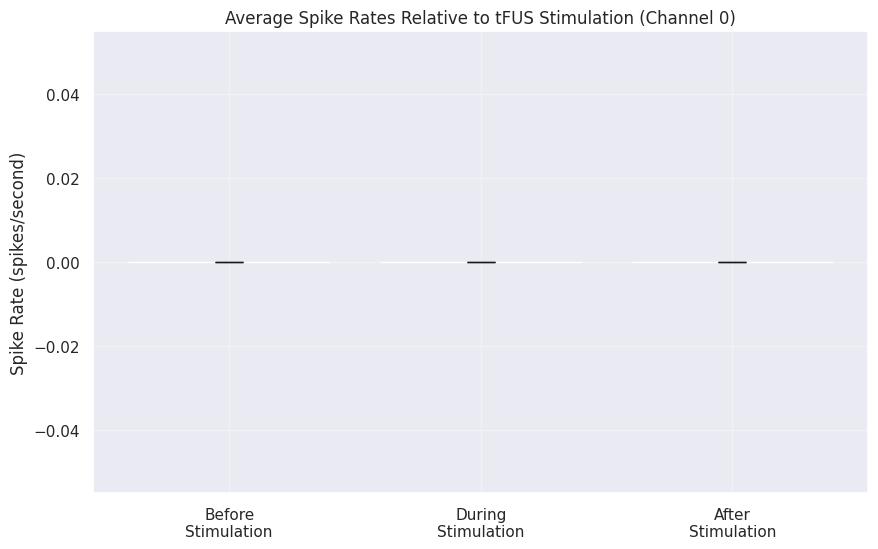

In [14]:
# Analyze spike rates across a small number of trials
num_trials_to_analyze = 5  # Reduced to speed up execution
window_before = 0.2  # seconds (reduced)
window_during = trial_durations[0]  # seconds - use the first trial's duration
window_after = 0.2   # seconds (reduced)

spike_counts_before = np.zeros(num_trials_to_analyze)
spike_counts_during = np.zeros(num_trials_to_analyze)
spike_counts_after = np.zeros(num_trials_to_analyze)

for i in range(min(num_trials_to_analyze, len(trial_start_times))):
    trial_start = trial_start_times[i]
    trial_stop = trial_stop_times[i]

    # Calculate indices for before stimulation
    before_start_idx = int((trial_start - window_before) * electrical_series.rate)
    before_stop_idx = int(trial_start * electrical_series.rate)

    # Check boundaries
    if before_start_idx < 0:
        continue

    # Calculate indices for during stimulation
    during_start_idx = int(trial_start * electrical_series.rate)
    during_stop_idx = int(trial_stop * electrical_series.rate)

    # Calculate indices for after stimulation
    after_start_idx = int(trial_stop * electrical_series.rate)
    after_stop_idx = int((trial_stop + window_after) * electrical_series.rate)

    if after_stop_idx >= electrical_series.data.shape[0]:
        continue

    # Load data for each segment
    before_data = electrical_series.data[before_start_idx:before_stop_idx, channel_to_analyze]
    during_data = electrical_series.data[during_start_idx:during_stop_idx, channel_to_analyze]
    after_data = electrical_series.data[after_start_idx:after_stop_idx, channel_to_analyze]

    # Detect spikes
    before_spikes = detect_spikes(before_data, threshold_factor=5.0, fs=electrical_series.rate)
    during_spikes = detect_spikes(during_data, threshold_factor=5.0, fs=electrical_series.rate)
    after_spikes = detect_spikes(after_data, threshold_factor=5.0, fs=electrical_series.rate)

    # Count spikes
    spike_counts_before[i] = len(before_spikes)
    spike_counts_during[i] = len(during_spikes)
    spike_counts_after[i] = len(after_spikes)

# Convert to spike rates (spikes per second)
spike_rates_before = spike_counts_before / window_before
spike_rates_during = spike_counts_during / window_during
spike_rates_after = spike_counts_after / window_after

# Calculate means and standard errors
mean_rate_before = np.mean(spike_rates_before)
mean_rate_during = np.mean(spike_rates_during)
mean_rate_after = np.mean(spike_rates_after)

sem_before = np.std(spike_rates_before) / np.sqrt(num_trials_to_analyze)
sem_during = np.std(spike_rates_during) / np.sqrt(num_trials_to_analyze)
sem_after = np.std(spike_rates_after) / np.sqrt(num_trials_to_analyze)

# Plot the results
plt.figure(figsize=(10, 6))
bars = plt.bar([0, 1, 2], [mean_rate_before, mean_rate_during, mean_rate_after],
        yerr=[sem_before, sem_during, sem_after], capsize=10)
plt.xticks([0, 1, 2], ['Before\nStimulation', 'During\nStimulation', 'After\nStimulation'])
plt.ylabel('Spike Rate (spikes/second)')
plt.title(f'Average Spike Rates Relative to tFUS Stimulation (Channel {channel_to_analyze})')
plt.grid(True, alpha=0.3)

## Creating a PSTH (Peri-Stimulus Time Histogram)

Let's create a peri-stimulus time histogram to visualize the timing of spikes relative to the stimulus onset.

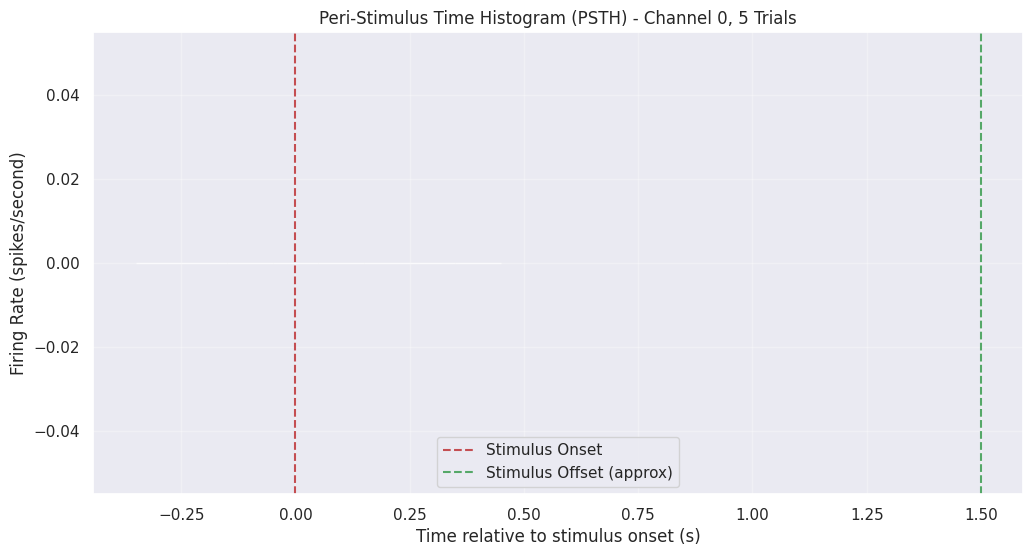

In [15]:
# Create PSTH across a small number of trials
num_trials_psth = 5  # Reduced for faster execution
window_before = 0.3  # seconds (reduced)
window_after = 0.5   # seconds (reduced)
bin_size = 0.1       # 100 ms bins (increased bin size to reduce computation)

# Create bins for histogram
bins = np.arange(-window_before, window_after + bin_size, bin_size)
psth_counts = np.zeros(len(bins) - 1)

trials_included = 0
for i in range(min(num_trials_psth, len(trial_start_times))):
    trial_start = trial_start_times[i]

    # Calculate indices
    start_idx = int((trial_start - window_before) * electrical_series.rate)
    stop_idx = int((trial_start + window_after) * electrical_series.rate)

    # Check boundaries
    if start_idx < 0 or stop_idx >= electrical_series.data.shape[0]:
        continue

    # Load data
    data = electrical_series.data[start_idx:stop_idx, channel_to_analyze]

    # Detect spikes
    spike_times = detect_spikes(data, threshold_factor=5.0, fs=electrical_series.rate)

    # Convert to time relative to stimulus onset
    spike_times_rel = spike_times - window_before

    # Add to histogram
    hist, _ = np.histogram(spike_times_rel, bins=bins)
    psth_counts += hist
    trials_included += 1

# Convert to spikes per second
psth_rate = psth_counts / (bin_size * trials_included)

# Plot PSTH
plt.figure(figsize=(12, 6))
plt.bar(bins[:-1], psth_rate, width=bin_size, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label='Stimulus Onset')
plt.axvline(x=trial_durations[0], color='g', linestyle='--', label='Stimulus Offset (approx)')

plt.xlabel('Time relative to stimulus onset (s)')
plt.ylabel('Firing Rate (spikes/second)')
plt.title(f'Peri-Stimulus Time Histogram (PSTH) - Channel {channel_to_analyze}, {trials_included} Trials')
plt.legend()
plt.grid(True, alpha=0.3)

## Comparing Different Files (tFUS Parameters)

This dataset includes recordings with different tFUS parameters. Let's compare neuronal responses across two different conditions.

**Note**: In this demonstration, we use a small subset of trials to keep computation time reasonable. For more thorough analysis, you might want to increase the number of trials analyzed.

In [16]:
# Load a second file with different parameters
asset_id2 = "6b9aa3e6-2389-4f84-a2d0-a3201894ad3c"  # Subject BH589, fifth session

# URL for loading the data through lindi
lindi_url2 = f"https://lindi.neurosift.org/dandi/dandisets/001363/assets/{asset_id2}/nwb.lindi.json"

# Load the second file
f2 = lindi.LindiH5pyFile.from_lindi_file(lindi_url2)
nwb2 = pynwb.NWBHDF5IO(file=f2, mode='r').read()

# Display basic info about both files
print("File 1 identifier:", nwb.identifier)
print("File 2 identifier:", nwb2.identifier)

File 1 identifier: BH589_1500_200_67_25V
File 2 identifier: BH589_1500_400_67_40V


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Let's compare the LFP (1-30 Hz) power between these two conditions.

/tmp/ipykernel_133763/4085094399.py:30: RuntimeWarning: overflow encountered in square
  lfp_power = np.mean(lfp_filtered**2)
/tmp/ipykernel_133763/4085094399.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([lfp_powers_file1, lfp_powers_file2], labels=[nwb.identifier, nwb2.identifier])


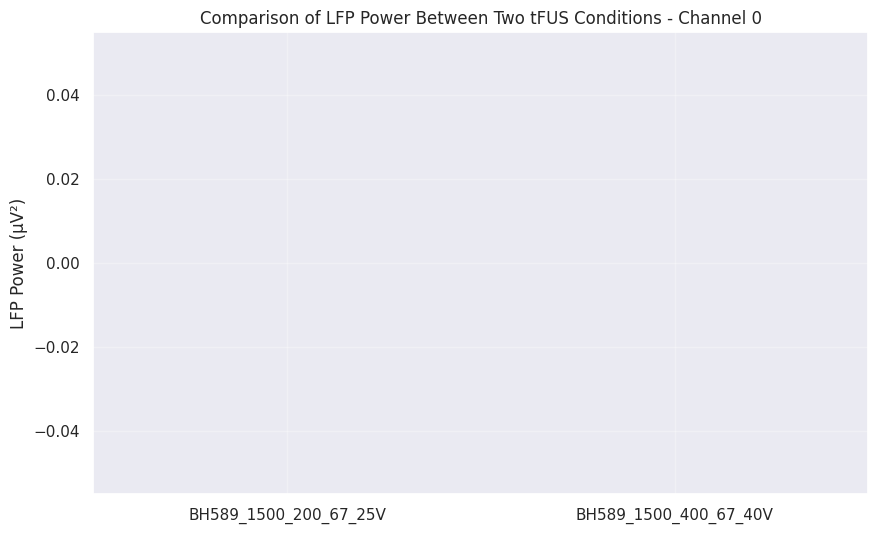

In [17]:
def get_trial_data_and_calculate_lfp_power(nwb_file, trial_index=0, channel_idx=0, window_before=0.5, window_after=0.5):
    """
    Get trial data from an NWB file and calculate LFP power.
    """
    # Get trial times and electrical series
    trials = nwb_file.intervals["trials"]
    electrical_series = nwb_file.acquisition["ElectricalSeries"]

    trial_start = trials['start_time'][trial_index]
    trial_stop = trials['stop_time'][trial_index]

    # Calculate indices
    start_idx = int((trial_start - window_before) * electrical_series.rate)
    stop_idx = int((trial_stop + window_after) * electrical_series.rate)

    # Check boundaries
    if start_idx < 0:
        start_idx = 0
    if stop_idx >= electrical_series.data.shape[0]:
        stop_idx = electrical_series.data.shape[0] - 1

    # Load data
    data = electrical_series.data[start_idx:stop_idx, channel_idx]

    # Filter to LFP band (1-30 Hz)
    b, a = signal.butter(4, [1, 30], 'bandpass', fs=electrical_series.rate)
    lfp_filtered = signal.filtfilt(b, a, data)

    # Calculate power
    lfp_power = np.mean(lfp_filtered**2)

    return lfp_power

# Calculate LFP power for a few trials in both files
num_trials = 3  # Reduced to avoid timeout issues
channel = 0
lfp_powers_file1 = []
lfp_powers_file2 = []

for i in range(num_trials):
    # File 1
    power1 = get_trial_data_and_calculate_lfp_power(nwb, trial_index=i, channel_idx=channel)
    lfp_powers_file1.append(power1)

    # File 2
    power2 = get_trial_data_and_calculate_lfp_power(nwb2, trial_index=i, channel_idx=channel)
    lfp_powers_file2.append(power2)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.boxplot([lfp_powers_file1, lfp_powers_file2], labels=[nwb.identifier, nwb2.identifier])
plt.ylabel('LFP Power (μV²)')
plt.title(f'Comparison of LFP Power Between Two tFUS Conditions - Channel {channel}')
plt.grid(True, alpha=0.3)

## Summary

In this notebook, we've explored neural spiking data in response to transcranial focused ultrasound stimulation from Dandiset 001363. We've:

1. Loaded and examined the structure of NWB files containing neural recordings
2. Visualized raw neural activity around stimulation trials
3. Analyzed the frequency content of neural signals before, during, and after stimulation
4. Detected spikes and calculated spike rates in response to stimulation
5. Created a peri-stimulus time histogram (PSTH) to visualize spike timing relative to stimulation
6. Compared neural responses between different tFUS stimulation parameters

This analysis provides a starting point for more in-depth investigations of how transcranial focused ultrasound affects neural activity in the rat somatosensory cortex. Researchers interested in this dataset could:

- Analyze changes in specific frequency bands (theta, beta, gamma) in response to stimulation
- Compare responses across different ultrasound parameters (pressure, duty cycle, PRF)
- Investigate latency of neural responses to stimulation
- Apply more advanced spike sorting techniques to identify and analyze individual neurons
- Examine spatial patterns of activation across different electrodes

Remember that this notebook was AI-generated and should be used as a starting point for your own analysis, with appropriate verification of results.